In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt

import copy

sys.path.insert(1, '../metadl/baselines/sentive_ai')
from sentive.sentive_vision_network import sentive_vision_network

from sentive.sentive_brain import sentive_brain

root_ep = 'episode_'
suf_eptest = '_1.csv'
root_test= 'test_'

episode = np.zeros([1,5,28,28,2])
test = np.zeros([5, 28,28,2])
for i in range(5):
    episode[0][i][:,:,0] = np.loadtxt(root_ep+str(i)+suf_eptest)
    episode[0][i][:,:,1] = np.loadtxt(root_ep+str(i)+suf_eptest)

    test[i][:,:,0] = np.loadtxt(root_test+str(i)+suf_eptest)
    test[i][:,:,1] = np.loadtxt(root_test+str(i)+suf_eptest)



$ >********* network: 0
nombre de neurones taille 1: 56


______________________________________________________________________________________
nrn2 id 57
new_x 9
new_y 7
central_pixel_id 1
nrn_pxl_map[new_y][x] 1.0
tmp_sub_pxl_map :
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 2. 3.]]
tmp_list_sub_pxl [0, 2, 3]
nrn_pxl_id 2
nrn_pxl id & weight : 2 0.9633017778396606
nrn_pxl_id 3
nrn_pxl id & weight : 3 0.9887948036193848
x_composant [0.0, 0.9887948036193848]
y_composant [0.9633017778396606, 0.9887948036193848]
vecteur orientation sans shift: 0.506529652790199 1.0
PROCHAIN NEURONE: [new_x: 10 , new_y: 8 ]
PROCHAIN NEURONE SANS CHANGEMENT: [new_x: 10 , new_y: 8 ]
mtrx_weights_pxl:
 [[0.         0.         0.        ]
 [0.         0.94592118 0.        ]
 [0.         0.96330178 0.9887948 ]]
neurone a supprimer dans la matrice : x : 2 y: 2
mtrx_weights_pxl:
 [[0.         0.         0.        ]
 [0.         0.94592118 0.        ]
 [0.         0.96330178 0.        ]]
barycentre [1.         1.50455175]
##

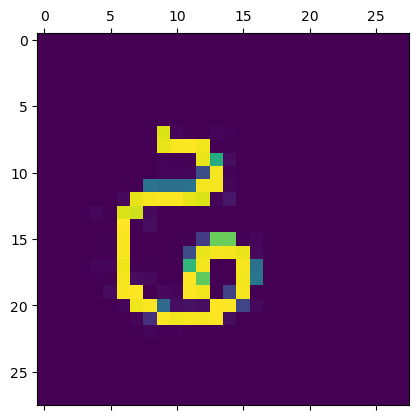

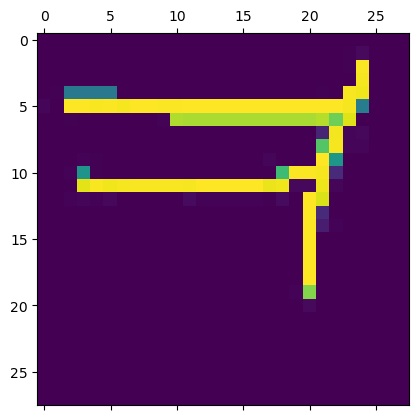

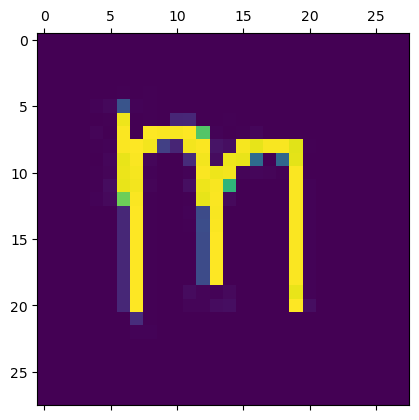

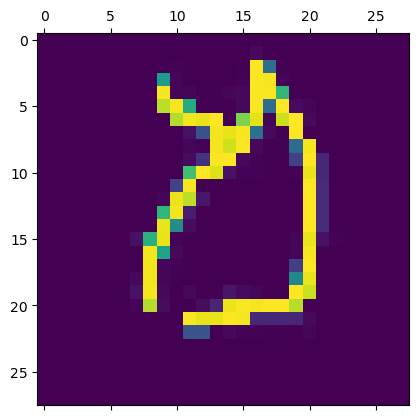

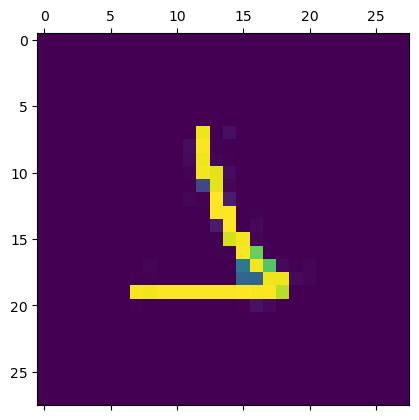

In [2]:
sbrain = sentive_brain(episode,5)

In [3]:
def compare_matrices(desired_mtrx, mtrx):
    if desired_mtrx.shape != mtrx.shape:
        raise ValueError("Les deux matrices n'ont pas la même forme")
    
    corr_matrix = np.corrcoef(desired_mtrx.flatten(), mtrx.flatten())
    similarity_score = np.abs(corr_matrix[0, 1]).mean()
    print(corr_matrix[0, 1])
    
    return similarity_score

In [4]:
def find_line(x1, y1, x2, y2):
    if x1 == x2:
        return (None, x1)
    elif y1 == y2:
        return (0, y1)
    else:
        a = (y2 - y1) / (x2 - x1)
        b = y1 - a * x1
        return (a, b)


def dot_on_line(x, y, a, b):
    return y == a * x + b

In [5]:
# to be removed                                                    
char_id = 1
self = sbrain.nnet[char_id]        
# to be removed 


In [6]:
x = 3.14
score = 1-x*2/np.pi
print("score:",score)

score: -0.9989860852342056


In [7]:
sbrain.nnet[char_id].nrn_tls.get_neuron_from_id(96)

{'_id': 96,
 'schema_version': 2,
 'type': 'sentive_vision_curve',
 'layer_id': 2,
 'DbConnectivity': {'pre_synaptique': [95, 98, 99, 100, 101, 102],
  'post_synaptique': [],
  'lateral_connexion': [104],
  'anti_lateral': [83],
  'weights': {}},
 'meta': {'threshold': 0.7,
  'pending_nb_iteration': 7,
  'averaged_prediction': 0.0,
  'last_vector': {'x': 0.0, 'y': 0.0},
  'curve': {'starting_point': {'x': 20, 'y': 13},
   'basis_vector': {'x': 0.0, 'y': 1.0},
   'last_position': {'x': 20, 'y': 18},
   'nb_iteration': 6,
   'angle': 0.0,
   'acceleration': 0.0,
   'malm_angle': 0.0,
   'malm_acceleration': 0.0,
   'last_vector': {'x': 0.0, 'y': 1.0}},
  'pixels_matrix': []}}

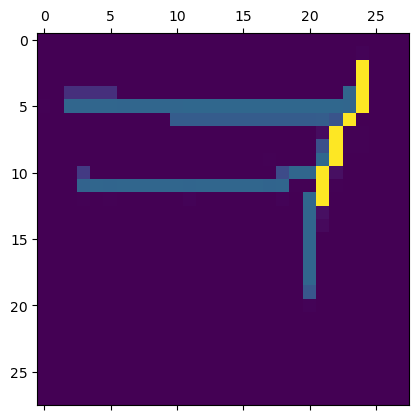

In [8]:
sbrain.nnet[char_id].show_receptive_field_id(83)

In [9]:
x = [0]
y = []
h = []
cumsum_x = 0
last_angle = 0
for nrn in sbrain.nnet[char_id].nrn_tls.lst_nrns:
    if nrn.neuron["type"] == "sentive_vision_curve":
        cumsum_x += nrn.neuron["meta"]["curve"]["nb_iteration"]
        x.append(cumsum_x)
        x.append(cumsum_x)
        print(nrn.neuron["_id"], ":", nrn.neuron["meta"]["curve"]["starting_point"], " *", nrn.neuron["meta"]["curve"]["nb_iteration"],"* ",cumsum_x,",",  nrn.neuron["meta"]["curve"]["angle"])
        last_angle = nrn.neuron["meta"]["curve"]["angle"]
        y.append(last_angle)
        y.append(last_angle)
        tmp_h = np.ones( nrn.neuron["meta"]["curve"]["nb_iteration"]) * last_angle
        h.extend(tmp_h)
y.append(last_angle)        
print("_______________________________________________________")
for nrn in sbrain.nnet[char_id].nrn_tls.lst_nrns:
    if nrn.neuron["type"] == "sentive_vision_line":
        print(nrn.neuron["_id"],  ":", nrn.neuron["meta"]["line"]["starting_point"] , " *", nrn.neuron["meta"]["line"]["nb_iteration"],"* ", )

83 : {'x': 24, 'y': 2}  * 11 *  11 , 0.12306477575714833
96 : {'x': 20, 'y': 13}  * 6 *  17 , 0.0
104 : {'x': 2, 'y': 4}  * 2 *  19 , -0.003874586588670995
108 : {'x': 5, 'y': 5}  * 16 *  35 , 0.0
126 : {'x': 3, 'y': 10}  * 2 *  37 , -1.109713418872709
130 : {'x': 5, 'y': 11}  * 14 *  51 , -0.056099868814103455
_______________________________________________________
84 : {'x': 24, 'y': 2}  * 8 * 
97 : {'x': 20, 'y': 13}  * 6 * 
105 : {'x': 2, 'y': 4}  * 3 * 
109 : {'x': 5, 'y': 5}  * 16 * 
127 : {'x': 3, 'y': 10}  * 1 * 
131 : {'x': 5, 'y': 11}  * 14 * 


In [116]:
def search_best_acc(str_curve, lst_checkpoints, min_acc, max_acc):
    if min_acc > max_acc:
        tmp_acc = copy.deepcopy(min_acc)
        min_acc = copy.deepcopy(max_acc)
        max_acc = copy.deepcopy(tmp_acc)

    split_acc = split_acc = np.mean([max_acc,  min_acc] )

    lst_result = []
    lst_acc = []

    for i in range(20):
        # print("min acc:", min_acc, ", split acc:", split_acc, ", max acc:", max_acc)
        result = sbrain.nnet[char_id].nrn_tls.check_curve_geometry(str_curve["starting_point"], str_curve["basis_vector"], str_curve["angle"], min_acc, str_curve["nb_iteration"], lst_checkpoints)
        # print("results min:", result)
        result_min = np.sum(result)

        result = sbrain.nnet[char_id].nrn_tls.check_curve_geometry(str_curve["starting_point"], str_curve["basis_vector"], str_curve["angle"], max_acc, str_curve["nb_iteration"], lst_checkpoints)
        # print("results max:", result)
        result_max = np.sum(result)
        
        result = sbrain.nnet[char_id].nrn_tls.check_curve_geometry(str_curve["starting_point"], str_curve["basis_vector"], str_curve["angle"], split_acc, str_curve["nb_iteration"], lst_checkpoints)
        # print("results split:", result)
        result_split = np.sum(result)
        lst_acc.append(split_acc)
        lst_result.append(result_split)

        avg_min = np.mean([result_min, result_split])
        avg_max = np.mean([result_max, result_split])

        if avg_min<avg_max:
            max_acc = copy.deepcopy(split_acc)
            # print(avg_min)
        else:
            min_acc = copy.deepcopy(split_acc)
            # print(avg_max)

        split_acc = np.mean([max_acc,  min_acc] )
        # print()

        
    print("min acc:", min_acc, ", split acc:", split_acc, ", max acc:", max_acc)
    print(lst_acc)
    print(lst_result)
    plt.scatter(lst_acc,lst_result)
    plt.show()
    return split_acc


nrn 83
suivant latéral: 96
distance: 1.4142135623730951
ok
new_curve: {'starting_point': {'x': 24, 'y': 2}, 'basis_vector': {'x': 0.0, 'y': 1.0}, 'angle': 0.12306477575714833, 'acc': -0.011187706887013484, 'nb_iteration': 11}
ck_pts: [{'x': 21, 'y': 12}, {'x': 20, 'y': 13}, {'x': 20, 'y': 18}]
results: [1.4762543726065864, 1.5038535998651503, 3.420382422181265] 
( 6.400490394653001 ) 

min acc: -0.018154316644321974 , split acc: -0.018154261414338024 , max acc: -0.018154206184354073
[-0.06515194010672559, -0.036195522281514216, -0.02171731336890853, -0.014478208912605687, -0.018097761140757108, -0.019907537254832817, -0.019002649197794964, -0.018550205169276038, -0.01832398315501657, -0.018210872147886838, -0.018154316644321974, -0.01812603889253954, -0.018140177768430757, -0.018147247206376366, -0.01815078192534917, -0.018152549284835572, -0.018153432964578775, -0.018153874804450375, -0.018154095724386175, -0.018154206184354073]
[18.130859376761656, 10.729488497511896, 3.1043713896184

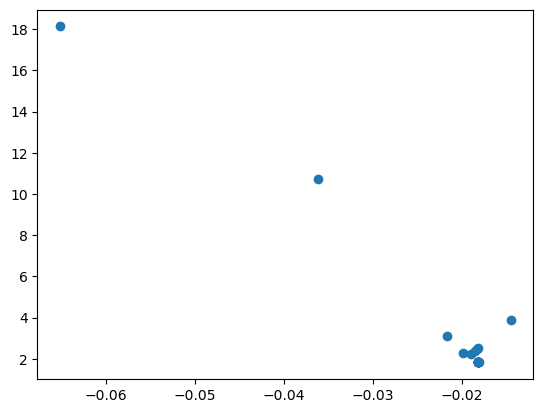

-0.018154261414338024


In [117]:
# tu récupères le premier neurone courbe
for nrn in sbrain.nnet[char_id].nrn_tls.lst_nrns:
    if nrn.neuron["type"] == "sentive_vision_curve":
        break
nrn = nrn.neuron
print("nrn",nrn["_id"])
# tu récupères le suivant (connexion latérale)

if len(nrn["DbConnectivity"]["lateral_connexion"])>0:
    nrn_suivant = sbrain.nnet[char_id].nrn_tls.get_neuron_from_id(nrn["DbConnectivity"]["lateral_connexion"][0])
    print("suivant latéral:", nrn_suivant["_id"])

    distance = sbrain.nnet[char_id].nrn_tls.calc_dist(nrn["meta"]["curve"]["last_position"],nrn_suivant["meta"]["curve"]["starting_point"])
    # tu vérifie la distance entre les deux
    print("distance:", distance)

    if distance<2:
        print("ok")
        # détermine les premiers paramètres de la nouvelle courbe
        new_curve = {}
        start = nrn["meta"]["curve"]["starting_point"]
        new_curve["starting_point"] = start
        b_v = nrn["meta"]["curve"]["basis_vector"]
        new_curve["basis_vector"] = b_v
        angl = nrn["meta"]["curve"]["angle"]
        new_curve["angle"] = angl
        acc = (nrn_suivant["meta"]["curve"]["angle"]-nrn["meta"]["curve"]["angle"])/nrn["meta"]["curve"]["nb_iteration"]
        new_curve["acc"] = acc
        n = nrn["meta"]["curve"]["nb_iteration"]
        new_curve["nb_iteration"] = n
        print("new_curve:", new_curve)
        ck_pts = []
        ck_pts.append(nrn["meta"]["curve"]["last_position"])
        ck_pts.append(nrn_suivant["meta"]["curve"]["starting_point"])
        ck_pts.append(nrn_suivant["meta"]["curve"]["last_position"])
        print("ck_pts:", ck_pts)
        results = sbrain.nnet[char_id].nrn_tls.check_curve_geometry(start, b_v, angl, acc, n, ck_pts)
        print("results:", results, "\n(",np.sum(results),") \n")
        # recherche dichotomique de l'accélération pour améliorer la géométrie et donc les resultats
        min_acc = (nrn_suivant["meta"]["curve"]["angle"]-nrn["meta"]["curve"]["angle"])/(nrn["meta"]["curve"]["nb_iteration"] + nrn_suivant["meta"]["curve"]["nb_iteration"])
        max_acc = (nrn_suivant["meta"]["curve"]["angle"]-nrn["meta"]["curve"]["angle"])

        print(search_best_acc(new_curve, ck_pts, min_acc, max_acc))
        

In [107]:
np.mean([-0.007239104456302843, - 0.12306477575714833])

-0.06515194010672559

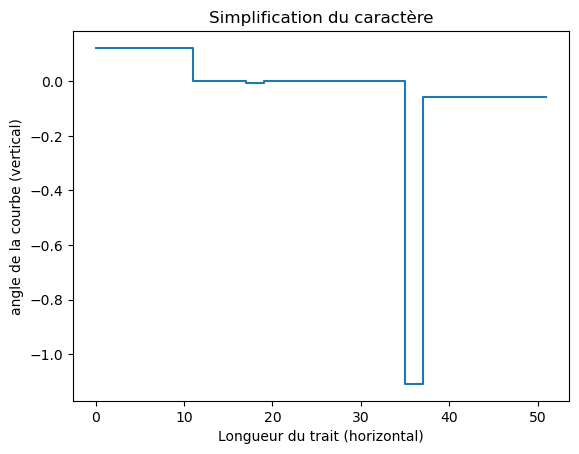

In [10]:
# tracer un graphique en escalier avec les points fournis
plt.plot(x, y, drawstyle='steps-post')

# ajouter des titres et des étiquettes d'axes
plt.title('Simplification du caractère')
plt.xlabel('Longueur du trait (horizontal)')
plt.ylabel('angle de la courbe (vertical)')

# afficher le graphique
plt.show()


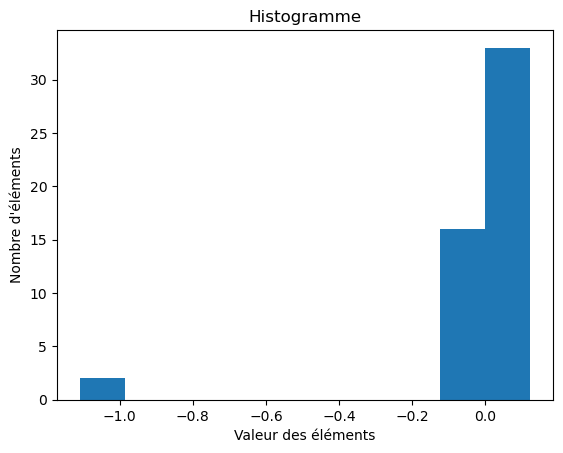

In [11]:
# tracer un histogramme avec les données fournies
plt.hist(h, bins=10)

# ajouter des titres et des étiquettes d'axes
plt.title('Histogramme')
plt.xlabel('Valeur des éléments')
plt.ylabel('Nombre d\'éléments')

# afficher le graphique
plt.show()


In [66]:
start = {
    "x": 24,
    "y": 2
}
b_v = {
    "x": 0,
    "y": 1
}
angl = 0.12306477575714833
acc = -0.12306477575714833/6.645
n = 17
ck_pts = []
ck_pts.append({
    "x" : 20,
    "y" : 12
})
ck_pts.append({
    "x" : 20,
    "y" : 13
})
ck_pts.append({
    "x" : 20,
    "y" : 18
})

print(sbrain.nnet[char_id].nrn_tls.check_curve_geometry(start, b_v, angl, acc, n, ck_pts))

[0.47068050626773655, 0.21485760114570812, 0.12788242233031416]


In [94]:
-0.12306477575714833/6.645

-0.0185199060582616

**nrn_drawer** : position de départ x 24 y 2
**nrn_drawer** : position intermédiaire x 24 y 4
**nrn_drawer** : position intermédiaire x 24 y 5
**nrn_drawer** : position intermédiaire x 23 y 6
**nrn_drawer** : position intermédiaire x 23 y 7
**nrn_drawer** : position intermédiaire x 23 y 8
**nrn_drawer** : position intermédiaire x 22 y 9
**nrn_drawer** : position intermédiaire x 22 y 10
**nrn_drawer** : position intermédiaire x 21 y 10
**nrn_drawer** : position intermédiaire x 21 y 11
**nrn_drawer** : position intermédiaire x 20 y 12
**nrn_drawer** : position intermédiaire x 20 y 13
**nrn_drawer** : position intermédiaire x 20 y 14
**nrn_drawer** : position intermédiaire x 19 y 15
**nrn_drawer** : position intermédiaire x 19 y 16
**nrn_drawer** : position intermédiaire x 19 y 17
**nrn_drawer** : position intermédiaire x 19 y 18
**nrn_drawer** : position intermédiaire x 20 y 19
**nrn_drawer** : position intermédiaire x 20 y 20
**nrn_drawer** : position intermédiaire x 21 y 21
**nrn_drawe

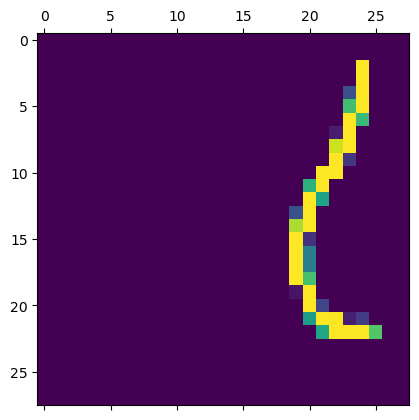

In [43]:
mtrx = np.zeros([28,28])
vector_1= {
    "x" : 0, 
    "y" : 1
}
angle =  0.12306477575714833
acc =  -0.12306477575714833/7
length = 24
start= {
    "x" : 24,
    "y" : 2
}

mtrx, angle, start, vector_1, _ = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)

In [14]:
vector_1 = {
    "x": 0.4223896117376803,
    "y": -1.1496568147231787
}
vector_2 = {
    "x": -1.0062661425036992,
    "y": -1.0
}
self.nrn_tls.calc_angle(vector_1, vector_2)

-1.1406168716388418

In [15]:
vector={
    "x": 0.11179970673855372,
    "y": 1.1153802556657226
}
angle = 1.0146139224297328
self.nrn_tls.draw_rotate_vector(vector, angle)

{'x': -0.8882421433163732, 'y': 0.6838115120356595}

In [16]:
x = -0.9559481185106888
y = -1.0421915345635244
k = np.sqrt(np.power(x,2)+np.power(y,2))

print("norme du vecteur", k)
print("normalisation du vecteur")
print("x",x/k)
print("y",y/k)
print("Allongement de la norme à sqrt2")
print("x",np.sqrt(2)*x/k)
print("y",np.sqrt(2)*y/k)

norme du vecteur 1.4142135623730951
normalisation du vecteur
x -0.6759573970614294
y -0.7369407013850822
Allongement de la norme à sqrt2
x -0.955948118510689
y -1.0421915345635244


**nrn_drawer** : position de départ x 9 y 7
**nrn_drawer** : position intermédiaire x 11 y 7
**nrn_drawer** : position intermédiaire x 12 y 8
**nrn_drawer** : position intermédiaire x 12 y 9
**nrn_drawer** : position intermédiaire x 12 y 10
**nrn_drawer** : position intermédiaire x 12 y 11
**nrn_drawer** : position intermédiaire x 11 y 12
**nrn_drawer** : position intermédiaire x 10 y 12
**nrn_drawer** : position intermédiaire x 9 y 12
**nrn_drawer** : position intermédiaire x 8 y 12
**nrn_drawer** : position intermédiaire x 7 y 11
**nrn_drawer** : position intermédiaire x 7 y 10
**nrn_drawer** : position intermédiaire x 7 y 9
**nrn_drawer** : position intermédiaire x 7 y 8
**nrn_drawer** : angle final: 0.39
**nrn_drawer** : position finale x 7 y 8
**nrn_drawer** : dernier vector {'x': 0.3500373909938908, 'y': -0.9367357284240797}


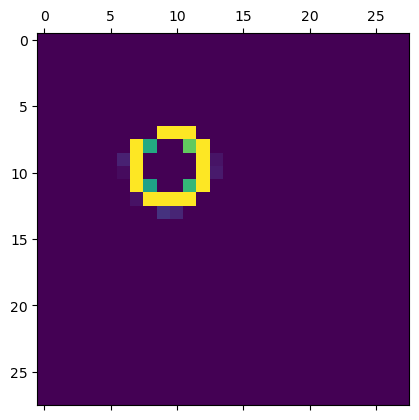

In [17]:
mtrx = np.zeros([28,28])
vector_1= {
    "x" : 1,
    "y" : 0
}
angle = 0.78/2
acc =  0
length = 14
start= {
    "x" : 9,
    "y" : 7
}

mtrx, angle, start, vector_1, _ = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)

In [18]:
45/9

5.0

**nrn_drawer** : position de départ x 9 y 7
**nrn_drawer** : position intermédiaire x 11 y 8
**nrn_drawer** : position intermédiaire x 12 y 8
**nrn_drawer** : angle final: 2.0243190925315058
**nrn_drawer** : position finale x 12 y 8
**nrn_drawer** : dernier vector {'x': 1.003854360540015, 'y': 0.4988473834556587}


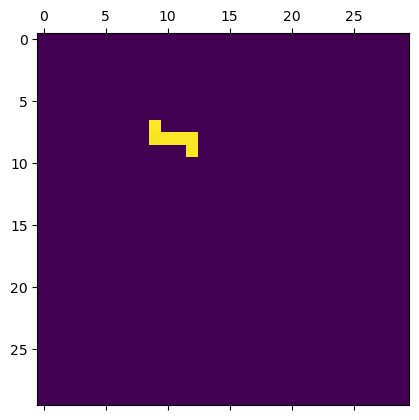

In [19]:
mtrx = np.zeros([30,30])
vector_1= {
    "x" : 0.506529652790199,
    "y" : 1
}
angle = -1.1019386507990419
acc =  1.5631288716652738
length = 3
start= {
    "x" : 9,
    "y" : 7
}

mtrx, angle, start, vector_1, _ = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)


In [20]:
int_counter = 0
for nrn in self.nrn_tls.lst_nrns:
    if nrn.neuron["type"] == "sentive_vision_matrix" and nrn.neuron["layer_id"]==2:
        # compte les neurones vision matrix
        int_counter += 1
print("Nombre de neurones vision matrix", int_counter)

Nombre de neurones vision matrix 52


**nrn_drawer** : position de départ x 12 y 8
**nrn_drawer** : position intermédiaire x 13 y 10
**nrn_drawer** : position intermédiaire x 12 y 10
**nrn_drawer** : position intermédiaire x 11 y 9
**nrn_drawer** : angle final: 1.2972384628321982
**nrn_drawer** : position finale x 11 y 9
**nrn_drawer** : dernier vector {'x': -0.3907409231662274, 'y': -1.0475311599008426}


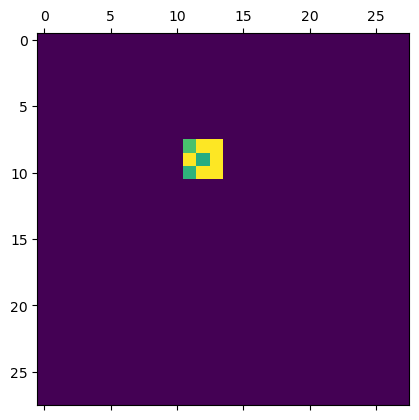

In [21]:
mtrx = np.zeros([28,28])
vector_1= {
    "x" : 1.0,
    "y" : 0.5
}
angle = 1.2972384628321982
acc =  0
length = 4
start= {
    "x" : 12,
    "y" : 8
}

mtrx, angle, start, vector_1, _ = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)

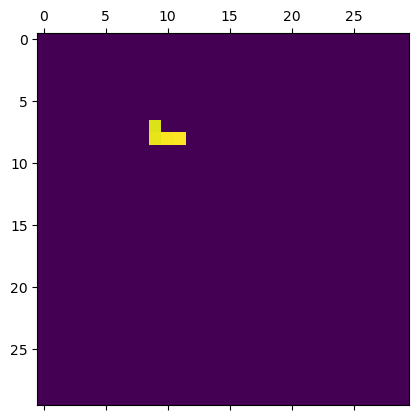

In [22]:
mtrx2 = np.zeros([30,30])
mtrx2 = sbrain.nnet[0].nrn_tls.get_neuron_receptive_field(1, mtrx2)
mtrx2 = sbrain.nnet[0].nrn_tls.get_neuron_receptive_field(2, mtrx2)
mtrx2 = sbrain.nnet[0].nrn_tls.get_neuron_receptive_field(3, mtrx2)
mtrx2 = sbrain.nnet[0].nrn_tls.get_neuron_receptive_field(4, mtrx2)
mtrx2 = mtrx2/5
plt.matshow(mtrx2)

In [23]:
#dimension de la liste des neurones
len(sbrain.nnet[0].nrn_tls.lst_nrns)

104

In [24]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(2)
# mtrx = nrn3["meta"]["pixels_matrix"]
# plt.matshow(mtrx)


{'_id': 2,
 'schema_version': 2,
 'type': 'sentive_vision_matrix',
 'layer_id': 1,
 'weight': 0.9633017778396606,
 'DbConnectivity': {'pre_synaptique': [],
  'post_synaptique': [],
  'lateral_connexion': [],
  'weights': {}},
 'meta': {'center': {'x': 9, 'y': 8}, 'matrix_width': 1}}

**nrn_drawer** : position de départ x 9 y 7
**nrn_drawer** : position intermédiaire x 11 y 9
**nrn_drawer** : position intermédiaire x 12 y 10
**nrn_drawer** : position intermédiaire x 13 y 11
**nrn_drawer** : position intermédiaire x 14 y 12
**nrn_drawer** : position intermédiaire x 15 y 13
**nrn_drawer** : position intermédiaire x 16 y 14
**nrn_drawer** : position intermédiaire x 17 y 15
**nrn_drawer** : angle final: 0
**nrn_drawer** : position finale x 17 y 15
**nrn_drawer** : dernier vector {'x': 1.0, 'y': 1.0}
save_pos [(10, 8), (12, 10), (11, 9), (15, 13), (17, 15), (14, 12), (16, 14), (9, 7), (13, 11)]


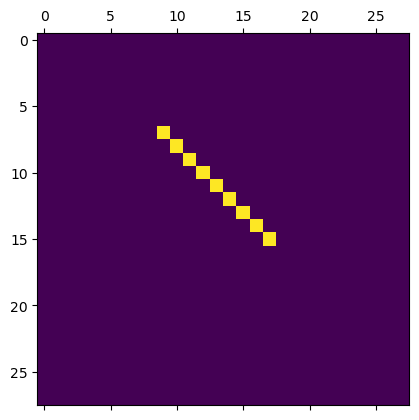

In [25]:
mtrx = np.zeros([28,28])
vector_1= {
    "x" : 1,
    "y" : 1
}
angle = 0
length = 8
start= {
    "x" : 9,
    "y" : 7
}
acc = 0

mtrx, angle, start, vector_1, save_pos = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)
print("save_pos", save_pos)

In [26]:
2*0.461190220866232

0.922380441732464

**nrn_drawer** : position de départ x 11 y 8
**nrn_drawer** : position intermédiaire x 13 y 9
**nrn_drawer** : angle final: 0.7243549945467616
**nrn_drawer** : position finale x 13 y 9
**nrn_drawer** : dernier vector {'x': 0.9021342216356463, 'y': 0.43145549730400484}
save_pos [(13, 9), (11, 8), (12, 8)]


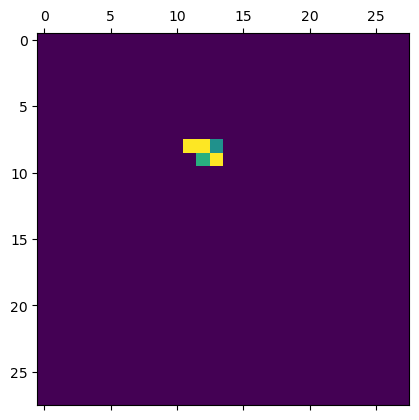

In [27]:
mtrx = np.zeros([28,28])
vector_1= {
    "x" : 0.9486832980505135,
    "y" : 0.3162277660168378
}
angle = 0.1243549945467616
length = 2
start= {
    "x" : 11,
    "y" : 8
}
acc = 0.6

mtrx, angle, start, vector_1, save_pos = sbrain.nnet[0].nrn_tls.nrn_drawer(mtrx, vector_1, angle, length, start,acc)
plt.matshow(mtrx)
print("save_pos", save_pos)

In [28]:
np.max(sbrain.nnet[0].episode[:,:,0])

1.0

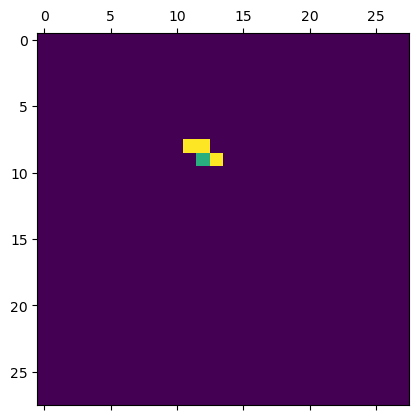

In [29]:
plt.matshow((sbrain.nnet[0].episode[:,:,0]>0) * mtrx)


In [30]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(39)

{'_id': 39,
 'schema_version': 2,
 'type': 'sentive_vision_matrix',
 'layer_id': 1,
 'weight': 0.7545397877693176,
 'DbConnectivity': {'pre_synaptique': [],
  'post_synaptique': [],
  'lateral_connexion': [],
  'weights': {}},
 'meta': {'center': {'x': 12, 'y': 18}, 'matrix_width': 1}}

In [31]:
sbrain.nnet[0].nrn_tls.lst_nrns[0].neuron

{'_id': 1,
 'schema_version': 2,
 'type': 'sentive_vision_matrix',
 'layer_id': 1,
 'weight': 0.9459211826324463,
 'DbConnectivity': {'pre_synaptique': [],
  'post_synaptique': [],
  'lateral_connexion': [],
  'weights': {}},
 'meta': {'center': {'x': 9, 'y': 7}, 'matrix_width': 1}}

In [32]:
sbrain.nnet[0].nb_nrn_pxls

56

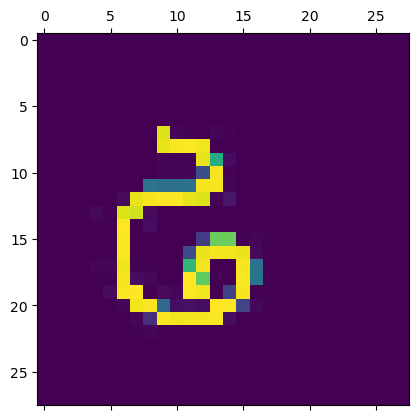

In [33]:
sbrain.nnet[0].show_receptive_field_id(40)

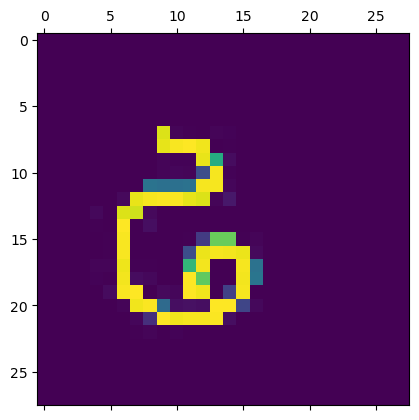

In [34]:
sbrain.nnet[0].show_receptive_field_id(52)

In [35]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(119)

''

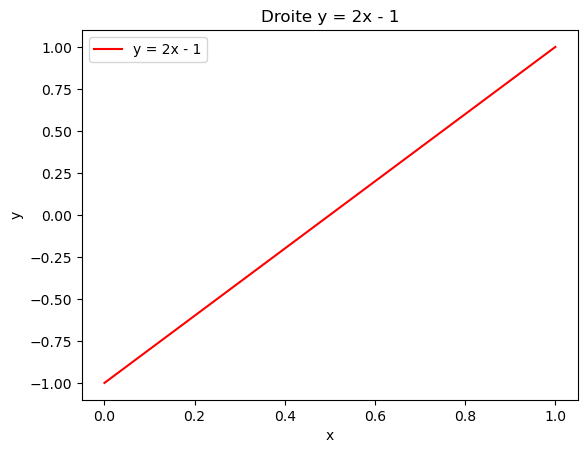

In [36]:
    # Définition des bornes pour x
    x_min = 0
    x_max = 1

    # Génération d'un tableau de valeurs pour x
    x = np.linspace(x_min, x_max)

    # Calcul des valeurs correspondantes pour y
    y = 2 * x - 1

    # Tracé de la droite
    plt.plot(x, y, 'r-', label='y = 2x - 1')

    # Configuration du graphique
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Droite y = 2x - 1')
    plt.legend()

    # Affichage du graphique
    plt.show()

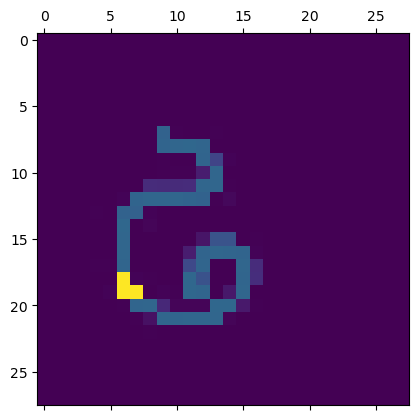

In [37]:
sbrain.nnet[0].show_receptive_field_id(83)

In [38]:
nrn_1 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(75)
vector_1 = nrn_1["meta"]["glbl_prm"]["u_axis"]
nrn_2 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(70)
vector_2 = nrn_2["meta"]["glbl_prm"]["u_axis"]
sbrain.nnet[0].nrn_tls.calc_angle(vector_1, vector_2)

KeyError: 'glbl_prm'

In [ ]:
np_c_1 = np.array([-0.52573111, 0.85065081])
np_c_2 = np.array([-0.52573111, 0.85065081])

In [ ]:
np.arccos(np.sum(np.multiply(np_c_1,np_c_2))/(np.sqrt(np.sum(np.power(np_c_1,2)))*np.sqrt(np.sum(np.power(np_c_2,2)))))

In [ ]:
X = []
Y = []
u_x = []
u_y = []
nb = 0
for nrn in sbrain.nnet[0].nrn_tls.lst_nrns:
    if nrn.neuron["layer_id"] == 2:
        nrn2 = nrn.neuron
        nb += 1
        X.append(nrn2["meta"]["glbl_prm"]["cg"]["x"])
        Y.append(nrn2["meta"]["glbl_prm"]["cg"]["y"])
        u_x.append(nrn2["meta"]["glbl_prm"]["u_axis"]["x"])
        u_y.append(nrn2["meta"]["glbl_prm"]["u_axis"]["y"])
q = plt.quiver(X,Y,u_x,u_y)
for nrn in sbrain.nnet[0].nrn_tls.lst_nrns:
    if nrn.neuron["layer_id"] == 2:
        nrn2 = nrn.neuron
        x = nrn2["meta"]["glbl_prm"]["cg"]["x"]
        y = nrn2["meta"]["glbl_prm"]["cg"]["y"]
        plt.text(x,y, str(nrn2["_id"]))
        for key in nrn2["DbConnectivity"]['angles']:
            y += 0.5
            angle = nrn2["DbConnectivity"]['angles'][key]
            angle = np.abs(angle)
            if angle > (np.pi)/2:
                angle = np.pi - angle
            if angle ==0:
                color = "green"
            elif angle < 0.1:
                color = "yellow"
            elif angle < 0.4:
                color = "orange"
            elif angle < 0.8:
                color = "red"
            else :
                color = "purple"
            plt.text(x,y, str(key),color=color)
            
print(nb)

In [ ]:
angles = []
for nrn in sbrain.nnet[0].nrn_tls.lst_nrns:
    if nrn.neuron["layer_id"] == 2:
        nrn2 = nrn.neuron
        for angle in nrn2["DbConnectivity"]['angles'].values():
            angle = np.abs(angle)
            if angle > (np.pi)/2:
                angle = np.pi - angle
            angles.append(angle)
            
plt.hist(angles)

In [ ]:
def generate_comment(text):
    """
    Generates a formatted comment string.
    
    Parameters
    ----------
    text : str
        The text to be used in the comment.
    
    Returns
    -------
    str
        The formatted comment string.
    """
    comment = "".join(["* " + line for line in text.splitlines()])
    return "/**\n" + comment + "\n*/"


In [ ]:
generate_comment("This is a test")


In [ ]:
np.diff([0.46364760900080615, 0.0, 0.5563215839986531, 0.4331511312763392, 1.04497122052071, -0.4189906125041946, -0.36640755089325333, 0.0, 0.32175055439664196, 0.46364760900080565, 0.4189906125041958, 0.36640755089325294, 0.0, 0.0, 0.3217505543966417, 0.46364760900080615, 0.16964630722702223, 0.12435499454676169, 0.49139686162366436, 0.0, 0.32175055439664196, -1.10714871779409, 1.4781223517970488, 0.3866752767716308])


In [ ]:
plt.plot([-0.46364761,  0.55632158, -0.12317045,  0.61182009, -1.46396183,
        0.05258306,  0.36640755,  0.32175055,  0.14189705, -0.044657  ,
       -0.05258306, -0.36640755,  0.        ,  0.32175055,  0.14189705,
       -0.2940013 , -0.04529131,  0.36704187, -0.49139686,  0.32175055,
       -1.42889927,  2.58527107, -1.09144708])

In [ ]:
# Affiche un un graphique d'une matrice de données
def plot_matrix(point_data, mat_dim=(28, 28)):
    """
    Plots a matrix of data.
    
    Parameters
    ----------
    matrix : list
        The matrix of data to be plotted.
    mat_dim : tuple
        The dimensions of the matrix.
    """
    # Create an empty matrix of zeros of mat_dim dimensions
    matrix = np.zeros(mat_dim)
    # For each element in the matrix
    for point in point_data:
        # Set the value of the element to the value of the matrix
        matrix[point[1]][point[0]] +=1
    # Plot the matrix   
    plt.imshow(np.array(matrix).reshape(mat_dim), cmap='gray')
    plt.show()
plot_matrix([(11, 8), (9, 7), (9, 8), (10, 8)])

In [ ]:
# nrn3:96
plot_matrix([(11, 8), (12, 8), (10, 8), (12, 9)])

In [ ]:
# nrn3:97
plot_matrix([(11, 8), (13, 10), (12, 8), (12, 9)])

In [ ]:
#nrn3:98
plot_matrix([(12, 11), (13, 10), (13, 11), (12, 9)])


In [ ]:
# nrn3:99
plot_matrix([(13, 10), (11, 12), (12, 12), (12, 11), (13, 11)])

In [ ]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(99)

In [ ]:
sbrain.nnet[0].nrn_tls.calc_angle({'x': 0.9899494936611662, 'y': -0.14142135623730961},{"x":0, "y":1} )

In [ ]:
sbrain.nnet[0].nrn_tls.calc_angle({"x":0, "y":1}, {'x': 1, 'y': -0.3} )